# Modeling and Simulation in Python

Case study: Spider-Man

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

### Spider-Man

In this notebook we'll develop a model of Spider-Man swinging from a springy cable of webbing attached to the top of the Empire State Building.  Initially, Spider-Man is at the top of a nearby builing, as shown in this diagram.

![](diagrams/spider-man.png)

The origin, `O`, is at the base of the Empire State Building.  The vector `H` represents position where the webbing is attached to the building, relative to `O`.  The vector `P` is the position of Spider-Man relative to `O`.  And `L` is the vector from the attachment point to Spider-Man.

By following the arrows from `O`, along `H`, and along `L`, we can see that 

`H + L = P`

So we can compute `L` like this:

`L = P - H`

The goals of this case study are:

1. Implement a model of this scenario to predict Spider-Man's trajectory.

2. Choose the right time for Spider-Man to let go of the webbing in order to maximize the distance he travels before landing.

I'll create a `Params` object to contain the quantities we'll need:

1. According to [the Spider-Man Wiki](http://spiderman.wikia.com/wiki/Peter_Parker_(Earth-616), Spider-Man weighs 76 kg.

2. Let's assume his terminal velocity is 60 m/s.

3. The length of the web is 100 m.

4. The initial angle of the web is 45 degrees to the left of straight down.

5. The spring constant of the web is 40 N / m when the cord is stretched, and 0 when it's compressed.

In [3]:
params = Params(height = 381 * m,
                g = 9.8 * m/s**2,
                mass = 75 * kg,
                area = 1 * m**2,
                rho = 1.2 * kg/m**3,
                v_term = 60 * m / s,
                length = 100 * m,
                angle = (270 - 45) * degree,
                k = 40 * N / m,
                V_0 = Vector(0, 0) * m/s,
                t_end = 30 * s)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,40.0 newton / meter
V_0,"[0.0 meter / second, 0.0 meter / second]"


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System with init, g, mass, rho, C_d, area, length,
             H, K, t_end
    """
    unpack(params)
    
    H = Vector(0, height)
    
    theta = angle.to(radian)
    x, y = pol2cart(theta, length)
    L_0 = Vector(x, y)
    P_0 = H + L_0
    
    init = State(x=P_0.x, y=P_0.y, vx=V_0.x, vy=V_0.y)
    C_d = 2 * mass * g / (rho * area * v_term**2)    
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, length=length,
                  H=H, k=k,
                  t_0=0*s, t_end=t_end)

Let's make a `System`

In [5]:
system = make_system(params)

,values
init,x -70.71067811865477 meter y 310.28932...
g,9.8 meter / second ** 2
mass,75 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.3402777777777778 dimensionless
area,1 meter ** 2
length,100 meter
H,"[0 meter, 381 meter]"
k,40.0 newton / meter
t_0,0 second


In [6]:
system.init

,values
x,-70.71067811865477 meter
y,310.28932188134524 meter
vx,0.0 meter / second
vy,0.0 meter / second


In [7]:
def drag_force(V, system):
    unpack(system)
    mag = rho * V.mag**2 * C_d * area / 2
    direction = -V.hat()
    f_drag = mag * direction
    return f_drag

In [8]:
params.V_0.mag

<Quantity(0.0, 'meter / second')>

In [9]:
drag_force(params.V_0, system)

<Quantity([-0. -0.], 'kilogram * meter / second ** 2')>

In [31]:
def spring_force(L, system):
    unpack(system)
    
    extension = L.mag - length
    mag = k * extension
    direction = -L.hat()
    print(type(direction))
    print(direction.units)
    f_spring = mag * direction
    return f_spring

In [32]:
angle = 45 * degree
theta = angle.to(radian)
x, y = pol2cart(theta, length+1*m)
L_0 = Vector(x, y)

<Quantity([71.4177849 71.4177849], 'meter')>

In [33]:
f_spring = spring_force(L_0, system)

<class 'modsim._Vector'>
dimensionless


<Quantity([-28.28427125 -28.28427125], 'newton')>

In [34]:
type(f_spring.magnitude)

numpy.ndarray

In [ ]:
# TODO: should Vector provide __rmul__?

Here's the slope function, including acceleration due to gravity, drag, and the spring force of the webbing.

In [12]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    P = Vector(x, y)
    V = Vector(vx, vy)
    L = P - H
    
    a_grav = Vector(0, -g)
    a_spring = spring_force(L, system) / mass
    a_drag = drag_force(V, system) / mass
    
    a = a_grav + a_drag + a_spring
    
    return vx, vy, a.x, a.y

As always, let's test the slope function with the initial conditions.

In [13]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(5.359248925640619e-15, 'meter / second ** 2')>,
 <Quantity(-9.799999999999995, 'meter / second ** 2')>)

And then run the simulation.

In [14]:
%time results, details = run_ode_solver(system, slope_func, max_step=0.2)
details

CPU times: user 2.45 s, sys: 12 ms, total: 2.46 s
Wall time: 2.45 s


,values
sol,None
t_events,[]
nfev,926
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


### Visualizing the results

We can extract the x and y components as `Series` objects.

The simplest way to visualize the results is to plot x and y as functions of time.

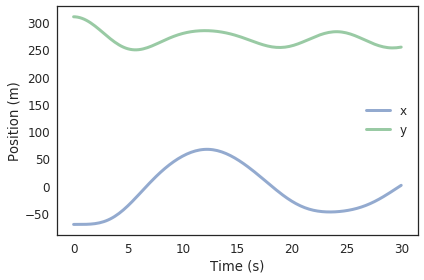

In [15]:
plot(results.x, label='x')
plot(results.y, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

We can plot the velocities the same way.

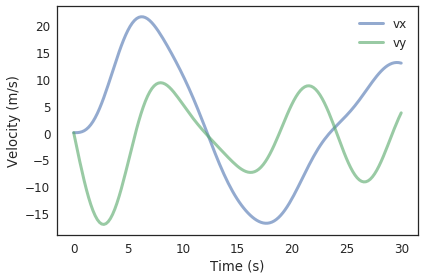

In [16]:
plot(results.vx, label='vx')
plot(results.vy, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

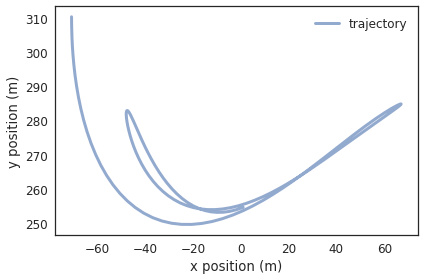

In [17]:
plot(results.x, results.y, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

In [18]:
params = Params(params, t_end=10*s)
system = make_system(params)
%time results, details = run_ode_solver(system, slope_func, max_step=0.2)


CPU times: user 860 ms, sys: 0 ns, total: 860 ms
Wall time: 854 ms


In [19]:
x, y, vx, vy = get_last_value(results)